In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
# Brightway imports
import bw2analyzer as ba
import bw2calc as bc
import bw2data as bd
import bw2io as bi
import brightway2 as bw

In [3]:
import pandas as pd
import numpy as np
import datetime
import os

In [4]:
# Custom functions
from useful_functions import get_inventory_dataset, init_simple_lca, multi_lcia, multi_contribution_analysis, calculate_projected_impacts
from visualisation_functions import plot_multilca_impacts, plot_contribution_analysis, plot_impacts_with_production, plot_incremental_impacts

Ore grade at year 2024: 0.011805115592480904


NameError: name 'np' is not defined

# Set projects, LCI and LCIA methods

In [5]:
BW_PROJECT = 'lib_rm' # insert your project name here
bd.projects.set_current(BW_PROJECT)

EI_DB = 'ecoinvent-3.10-cutoff' # name of ecoinvent database in your project
LIB_RM_DB = "LIB raw materials"

In [6]:
# Search for activities
# [a["name"] for a in bd.Database('LIB raw materials')]

In [7]:
#activity = bd.Database('ecoinvent-3.10-cutoff').search('copper mine operation and beneficiation, sulfide ore')
#selected_activity = [act for act in activity if act['location'] == 'CA']

In [8]:
INVENTORIES_EI = {
    ## Neodymium
    "Neodymium":        ("rare earth oxides production, from rare earth carbonate concentrate", "neodymium oxide", "RoW"),
    
    ## Copper
    "Copper concentrate, Canada": ('copper mine operation and beneficiation, sulfide ore', 'copper concentrate, sulfide ore', 'CA'),
    "Market for copper, cathode": ('market for copper, cathode', 'copper, cathode', 'GLO')
}

In [9]:
# From Istrate et al (2024)
# (name, reference product, location)
INVENTORIES = {
    "Lithium hydroxide, brine":        ("lithium hydroxide production, Salar de Atacama", "lithium hydroxide, battery grade", "CL"),
    "Lithium hydroxide, spodumene":    ("lithium hydroxide production, from Australian spodumene", "lithium hydroxide, battery grade", "CN"),
    "Cobalt":                ("cobalt sulfate production, from copper-cobalt ore, economic allocation", "cobalt sulfate", "CN"),
    "Nickel":                ("nickel sulfate production, average excluding China, economic allocation", "nickel sulfate", "GLO"),
    "Graphite, natural":     ("natural graphite production, battery grade, from Heilongjiang", "natural graphite, battery grade", "CN"),
    "Graphite, synthetic":   ("graphite powder coating", "synthetic graphite, battery grade", "CN"),
    
    "Lithium carbonate, brine":        ("lithium carbonate production, Salar de Atacama", "lithium carbonate, battery grade", "CL"),
    "Lithium carbonate, spodumene":    ("lithium carbonate production, from Australian spodumene", "lithium carbonate, battery grade", "CN"),
}

In [10]:
# Collect data from both the custom database and Ecoinvent database
INVENTORIES_ds = {}
INVENTORIES_ds.update(get_inventory_dataset(INVENTORIES, LIB_RM_DB))
INVENTORIES_ds.update(get_inventory_dataset(INVENTORIES_EI, EI_DB))

In [11]:
INVENTORIES_ds

{'Lithium hydroxide, brine': 'lithium hydroxide production, Salar de Atacama' (kilogram, CL, None),
 'Lithium hydroxide, spodumene': 'lithium hydroxide production, from Australian spodumene' (kilogram, CN, None),
 'Cobalt': 'cobalt sulfate production, from copper-cobalt ore, economic allocation' (kilogram, CN, None),
 'Nickel': 'nickel sulfate production, average excluding China, economic allocation' (kilogram, GLO, None),
 'Graphite, natural': 'natural graphite production, battery grade, from Heilongjiang' (kilogram, CN, None),
 'Graphite, synthetic': 'graphite powder coating' (kilogram, CN, None),
 'Lithium carbonate, brine': 'lithium carbonate production, Salar de Atacama' (kilogram, CL, None),
 'Lithium carbonate, spodumene': 'lithium carbonate production, from Australian spodumene' (kilogram, CN, None),
 'Neodymium': 'rare earth oxides production, from rare earth carbonate concentrate' (kilogram, RoW, None),
 'Copper concentrate, Canada': 'copper mine operation and beneficiation, 

In [6]:
bd.methods

Methods dictionary with 668 objects, including:
	('CML v4.8 2016', 'acidification', 'acidification (incl. fate, average Europe total, A&B)')
	('CML v4.8 2016', 'climate change', 'global warming potential (GWP100)')
	('CML v4.8 2016', 'ecotoxicity: freshwater', 'freshwater aquatic ecotoxicity (FAETP inf)')
	('CML v4.8 2016', 'ecotoxicity: marine', 'marine aquatic ecotoxicity (MAETP inf)')
	('CML v4.8 2016', 'ecotoxicity: terrestrial', 'terrestrial ecotoxicity (TETP inf)')
	('CML v4.8 2016', 'energy resources: non-renewable', 'abiotic depletion potential (ADP): fossil fuels')
	('CML v4.8 2016', 'eutrophication', 'eutrophication (fate not incl.)')
	('CML v4.8 2016', 'human toxicity', 'human toxicity (HTP inf)')
	('CML v4.8 2016', 'material resources: metals/minerals', 'abiotic depletion potential (ADP): elements (ultimate reserves)')
	('CML v4.8 2016', 'ozone depletion', 'ozone layer depletion (ODP steady state)')
Use `list(this object)` to get the complete list.

In [12]:
#bd.methods
IMPACT_METHODS = {
    "Climate change": ('IMPACT World+ v2.0.1, footprint version', 'climate change', 'carbon footprint'), 
    "Ecosystem quality": ('IMPACT World+ v2.0.1, footprint version', 'ecosystem quality', 'remaining ecosystem quality damage'),
    "Human health": ('IMPACT World+ v2.0.1, footprint version', 'human health', 'remaining human health damage'),
    "Water use": ('IMPACT World+ v2.0.1, footprint version', 'water use', 'water scarcity footprint')
                 }

In [ ]:
impact_categories = [
    "Climate change (kg CO2-Eq)", 
    "Ecosystem quality (PDF.m2.yr)", 
    "Human health (DALYs)", 
    "Water use (m3 world Eq deprived)"
]

# Specific impacts

In [13]:
# Initialize LCA object
lca = init_simple_lca(INVENTORIES_ds["Lithium hydroxide, brine"], method=IMPACT_METHODS )

In [14]:
specific_lca = {}
for rm in INVENTORIES_ds:
    impacts = multi_lcia(lca, INVENTORIES_ds[rm], IMPACT_METHODS)
    specific_lca[rm] = impacts

specific_lca = pd.DataFrame(specific_lca).T

In [15]:
specific_lca

,Climate change (kg CO2-Eq),Ecosystem quality (PDF.m2.yr),Human health (DALYs),Water use (m3 world Eq deprived)
"Lithium hydroxide, brine",7.670832,0.827068,0.000006,2.078440
"Lithium hydroxide, spodumene",17.180445,3.344400,0.000022,2.487335
Cobalt,14.927615,3.351673,0.000028,4.524261
Nickel,5.460966,6.702595,0.000033,1.033520
"Graphite, natural",10.541640,2.119473,0.000009,36.364382
"Graphite, synthetic",43.735114,7.392098,0.000033,4.378197
"Lithium carbonate, brine",3.610366,0.517874,0.000003,1.869038
"Lithium carbonate, spodumene",24.024092,4.659097,0.000031,3.387107
Neodymium,55.058910,72.895905,0.000079,36.117563
"Copper concentrate, Canada",1.249726,2.174542,0.000003,2.101341


Plot saved to results/lca_impacts.png


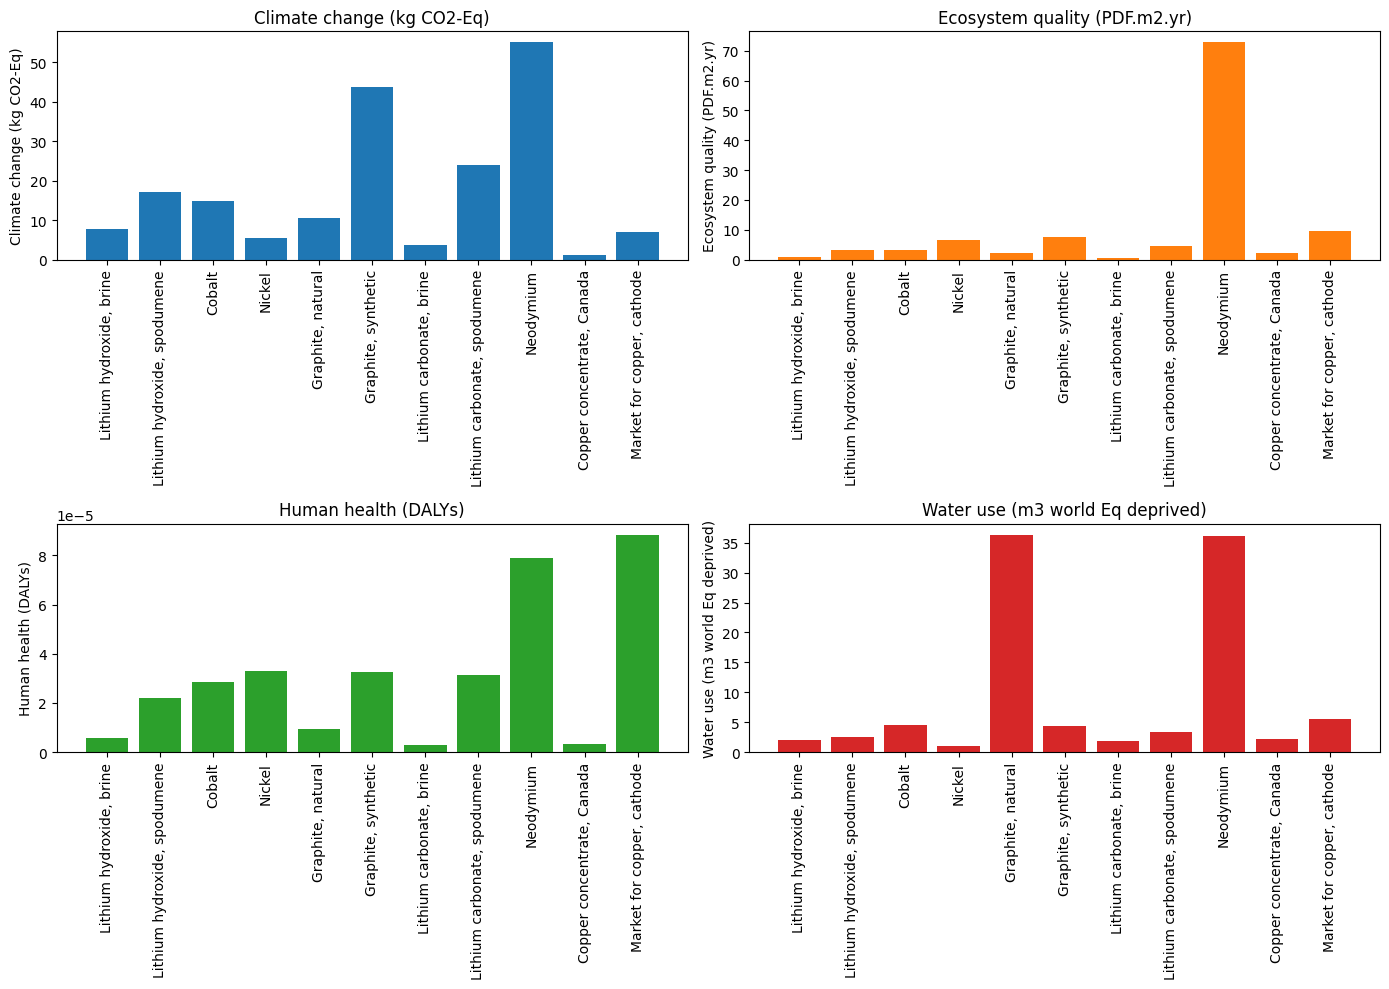

In [16]:
# Call the function
plot_multilca_impacts(specific_lca, 
                 impact_categories = [
    "Climate change (kg CO2-Eq)", 
    "Ecosystem quality (PDF.m2.yr)", 
    "Human health (DALYs)", 
    "Water use (m3 world Eq deprived)"], 
                 colors=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"], 
                 save_path="results/lca_impacts.png")

In [17]:
specific_lca.to_csv(f"results/specific_results_{datetime.datetime.today().strftime('%d-%m-%Y')}.csv", index_label="Raw material")

In [18]:
# Initialize a dictionary to store contribution results for each inventory
contribution_results = {}

# Loop through each inventory and perform contribution analysis
for rm_name, rm_ds in INVENTORIES_ds.items():
    lca = init_simple_lca(rm_ds)
    contributions = multi_contribution_analysis(lca, IMPACT_METHODS, top_n=10, threshold=0.01)  # Set your threshold here
    contribution_results[rm_name] = contributions

# Convert the results into a more readable format for analysis
contribution_dfs = {}

for rm_name, impacts in contribution_results.items():
    for impact_name, contributions in impacts.items():
        df = pd.DataFrame(contributions)
        df["Inventory"] = rm_name
        df["Impact Category"] = impact_name
        contribution_dfs[(rm_name, impact_name)] = df

# Combine all individual DataFrames into one for easy viewing
contribution_analysis_df = pd.concat(contribution_dfs.values(), ignore_index=True)

# Set "Inventory" and "Impact Category" as the row indices
contribution_analysis_df.set_index(["Inventory", "Impact Category"], inplace=True)


In [19]:
contribution_analysis_df

score   quantity  percentage  \
Inventory                  Impact Category                                    
Lithium hydroxide, brine   Climate change   2.546242  43.125706   33.193816   
                           Climate change   1.276628   1.174931   16.642628   
                           Climate change   0.693125   0.708695    9.035846   
                           Climate change   0.461016   0.026424    6.009992   
                           Climate change   0.449460   3.898652    5.859344   
...                                              ...        ...         ...   
Market for copper, cathode Water use        0.095290   0.489834    1.700653   
                           Water use        0.090593   0.807110    1.616834   
                           Water use        0.073927   0.058898    1.319384   
                           Water use        0.063327   0.039982    1.130202   
                           Water use        0.059110   0.047093    1.054944   

                                                                                         name  \
Inventory                  Impact Category                                                      
Lithium hydroxide, brine   Climate change   heat production, natural gas, at industrial fu...   
                           Climate change              quicklime production, in pieces, loose   
                           Climate change                   electricity production, hard coal   
                           Climate change   natural gas venting from petroleum/natural gas...   
                           Climate change   heat production, at hard coal industrial furna...   
...                                                                                       ...   
Market for copper, cathode Water use        copper mine operation and beneficiation, sulfi...   
                           Water use        hard coal mine operation and hard coal prepara...   
                           Water use        electricity production, hydro, reservoir, non-...   
                           Water use        electricity production, nuclear, pressure wate...   
                           Water use        electricity production, hydro, reservoir, non-...   

                                                                            reference product  
Inventory                  Impact Category                                                     
Lithium hydroxide, brine   Climate change           heat, district or industrial, natural gas  
                           Climate change                         quicklime, in pieces, loose  
                           Climate change                           electricity, high voltage  
                           Climate change                                 natural gas, vented  
                           Climate change   heat, district or industrial, other than natur...  
...                                                                                       ...  
Market for copper, cathode Water use                          copper concentrate, sulfide ore  
                           Water use                                                hard coal  
                           Water use                                electricity, high voltage  
                           Water use                                electricity, high voltage  
                           Water use                                electricity, high voltage  

[389 rows x 5 columns]

In [20]:
# Example usage
inventory_names = ["Lithium hydroxide, brine", "Lithium hydroxide, spodumene", "Cobalt"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
plot_contribution_analysis(contribution_analysis_df, inventory_names, colors, save_dir="results")

Plot saved to results/contribution_analysis_Lithium_hydroxide,_brine.png
Plot saved to results/contribution_analysis_Lithium_hydroxide,_spodumene.png
Plot saved to results/contribution_analysis_Cobalt.png


In [21]:
contribution_analysis_df.to_csv(f"results/contribution_analysis_{datetime.datetime.today().strftime('%d-%m-%Y')}.csv")

# Demand-related impacts

In [22]:
production_existing = pd.read_excel(r'data/scenarios_canadian_climate_institute.xlsx', sheet_name='Production_existing')
production_potential = pd.read_excel(r'data/scenarios_canadian_climate_institute.xlsx', sheet_name='Production_potential')
production_existing = production_existing[production_existing['Scenario']=='Domestic demand scenario']
production_potential = production_potential[production_potential['Scenario']=='Domestic demand scenario']

In [23]:
production_existing['Mineral'].unique()

array(['Cobalt', 'Copper', 'Lithium', 'Nickel', 'Graphite', 'Neodymium'],
      dtype=object)

In [24]:
specific_lca = specific_lca.reset_index().rename(columns={'index': 'Mineral'})
specific_lca

,Mineral,Climate change (kg CO2-Eq),Ecosystem quality (PDF.m2.yr),Human health (DALYs),Water use (m3 world Eq deprived)
0,"Lithium hydroxide, brine",7.670832,0.827068,0.000006,2.078440
1,"Lithium hydroxide, spodumene",17.180445,3.344400,0.000022,2.487335
2,Cobalt,14.927615,3.351673,0.000028,4.524261
3,Nickel,5.460966,6.702595,0.000033,1.033520
4,"Graphite, natural",10.541640,2.119473,0.000009,36.364382
5,"Graphite, synthetic",43.735114,7.392098,0.000033,4.378197
6,"Lithium carbonate, brine",3.610366,0.517874,0.000003,1.869038
7,"Lithium carbonate, spodumene",24.024092,4.659097,0.000031,3.387107
8,Neodymium,55.058910,72.895905,0.000079,36.117563
9,"Copper concentrate, Canada",1.249726,2.174542,0.000003,2.101341


In [25]:
# Define a manual mapping to link the mineral in the scenario with the LCI of our choice
mineral_to_material = {
    "Cobalt": "Cobalt",
    "Copper": "Copper concentrate, Canada",
    "Lithium": "Lithium carbonate, spodumene",
    "Nickel": "Nickel",
    "Graphite": "Graphite, natural",
    "Neodymium": "Copper concentrate, Canada"  
}


In [26]:
# Generate the projected impacts DataFrame
projected_impacts_existing_production = calculate_projected_impacts(production_existing, specific_lca, mineral_to_material)
projected_impacts_potential_production = calculate_projected_impacts(production_potential, specific_lca, mineral_to_material)


In [27]:
projected_impacts_existing_production

,Climate change (kg CO2-Eq),Ecosystem quality (PDF.m2.yr),Human health (DALYs),Water use (m3 world Eq deprived),Year,Mineral
0,6.174211e+07,1.386285e+07,117.461302,1.871280e+07,2018,Cobalt
1,5.124650e+07,1.150629e+07,97.493931,1.553179e+07,2019,Cobalt
2,4.831060e+07,1.084710e+07,91.908520,1.464198e+07,2020,Cobalt
3,5.685417e+07,1.276537e+07,108.162233,1.723136e+07,2021,Cobalt
4,3.785857e+07,8.500322e+06,72.024047,1.147417e+07,2022,Cobalt
...,...,...,...,...,...,...
133,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,2036,Neodymium
134,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,2037,Neodymium
135,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,2038,Neodymium
136,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,2039,Neodymium


In [28]:
# Plot impacts per production scenario
plot_impacts_with_production(projected_impacts_existing_production, production_existing, impact_categories, scenario_name='existing_production')
plot_impacts_with_production(projected_impacts_potential_production, production_potential, impact_categories, scenario_name='potential_production')


Combined plot saved to results\combined_impact_existing_production.png
Combined plot saved to results\combined_impact_potential_production.png


In [34]:
# Plot incremental impacts from potential production to existing production
plot_incremental_impacts(projected_impacts_existing_production, projected_impacts_potential_production,
                                 production_existing, production_potential, 
                                 impact_categories, save_dir="results", scenario_name="incremental_comparison")


Incremental impact stacked plot saved to results\incremental_impact_incremental_comparison_stacked.png
